<font color="#CC3D3D"><p>
# Build models (ver.1027)

- `INPUT`: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- `OUTPUT`: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

### Imports 패키지

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np


# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline


# EDA
import klib


# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile


# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin


# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### 1. Read Data

In [2]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv('X_train.csv', encoding='cp949')
test = pd.read_csv('X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점
1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점
2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,...,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점
3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점
4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,화장품,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,14,5898679,23976000,8,7,7,8,40,0.642857,...,1.032269e+07,1.750000,36256000.0,5.0,44158500.0,7.0,82581500,14,골프,부산본점
5978,480000,1,480000,480000,1,1,1,1,0,0.000000,...,4.800000e+05,1.000000,NaN,NaN,NaN,NaN,480000,1,섬유잡화,광주점
5979,260003790,71,3662025,25750000,38,28,19,19,18,0.915493,...,1.368441e+07,3.736842,121061000.0,21.0,159653190.0,39.0,260003790,71,남성 캐주얼,본 점
5980,88991520,18,4943973,18120000,9,7,5,5,60,0.444444,...,1.779830e+07,3.600000,7528530.0,2.0,41243840.0,10.0,88991520,18,육류,본 점


### 2. EDA

In [3]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

GridSpec(6, 6)

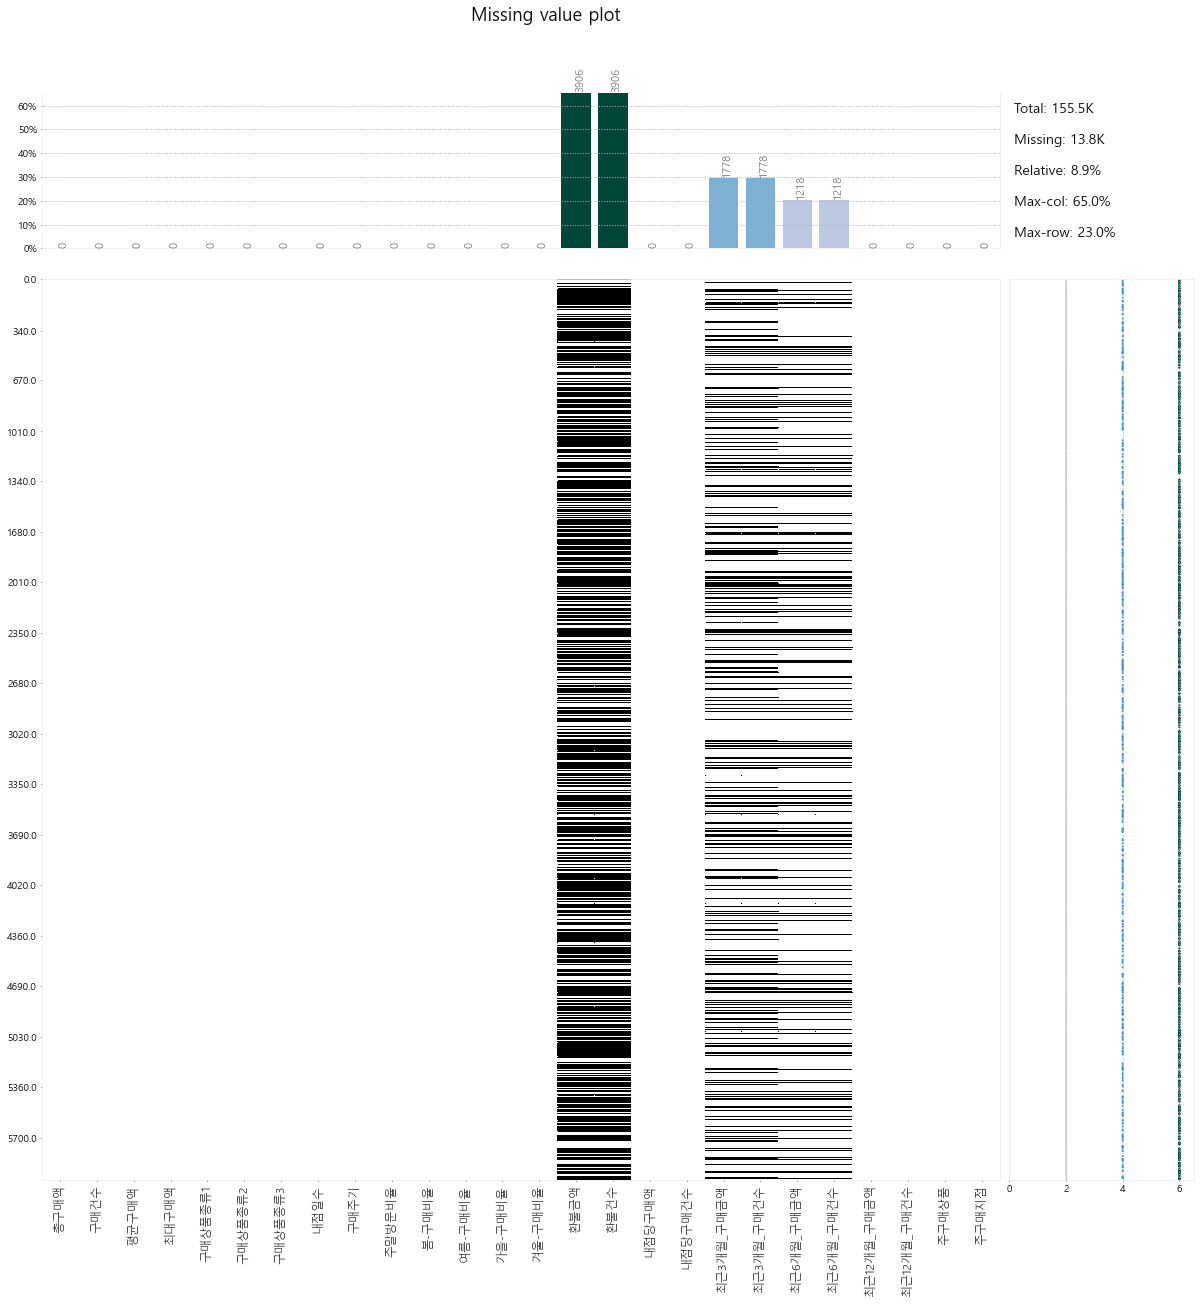

In [4]:
# 결측값 파악

klib.missingval_plot(features)

Note: The number of non binary numerical features is very large (24), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.
Dropped 3906 missing values from column 환불금액.
Dropped 3906 missing values from column 환불건수.
Dropped 1778 missing values from column 최근3개월_구매금액.
Dropped 1778 missing values from column 최근3개월_구매건수.


<AxesSubplot:xlabel='최근3개월_구매건수', ylabel='Density'>

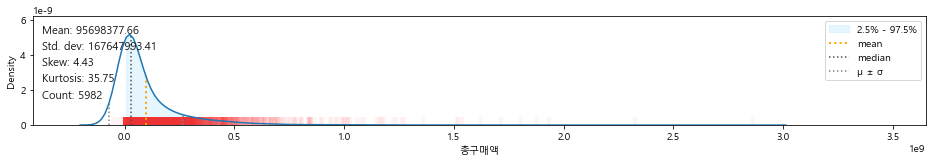

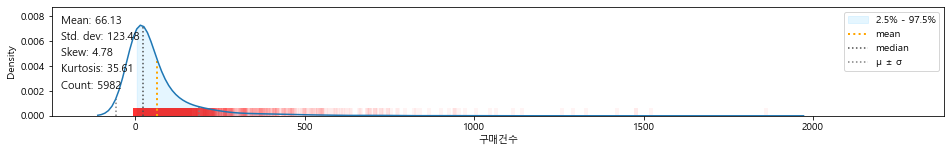

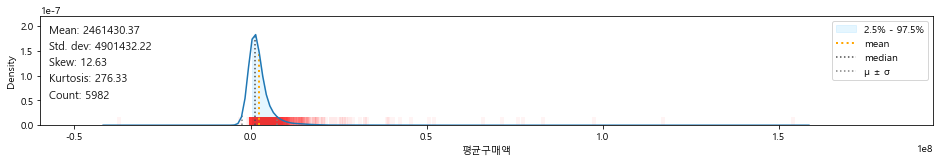

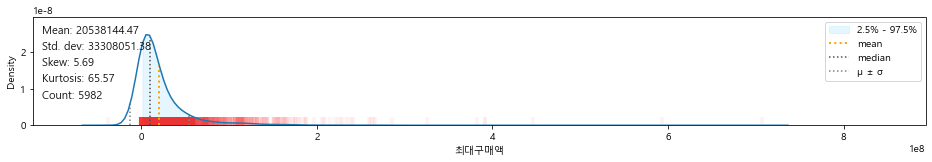

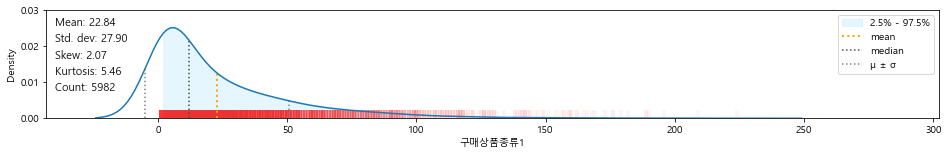

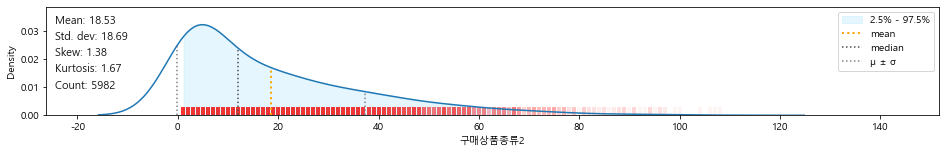

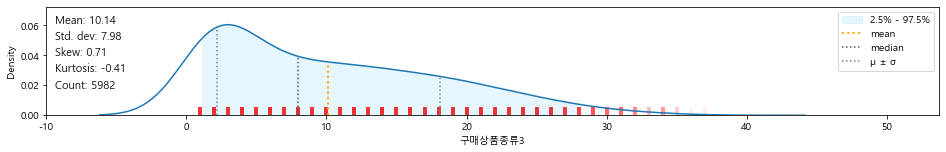

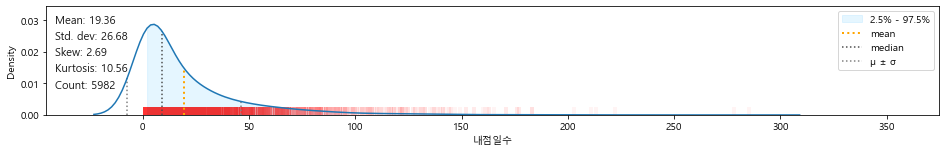

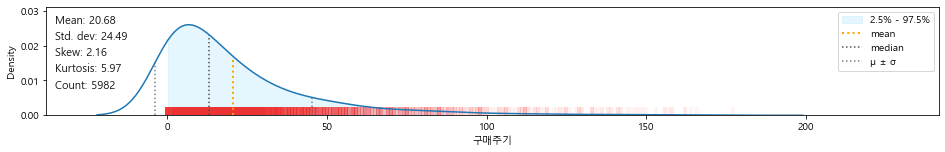

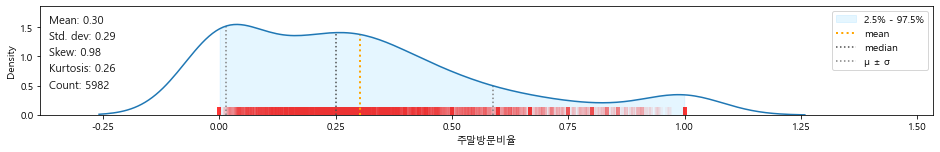

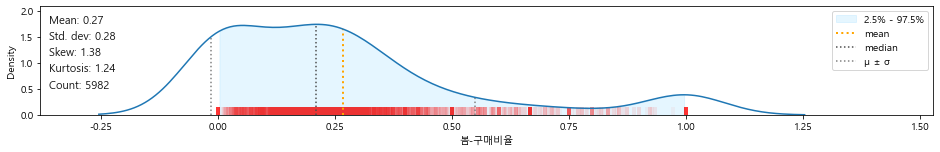

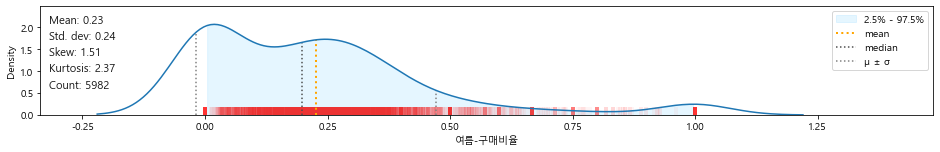

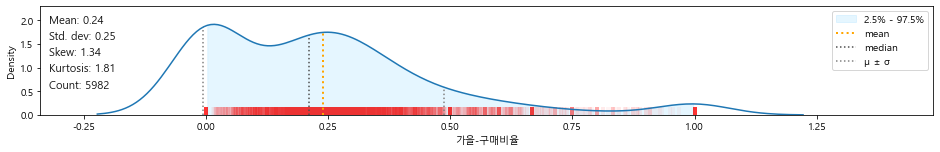

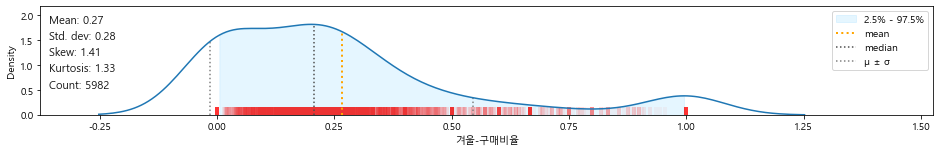

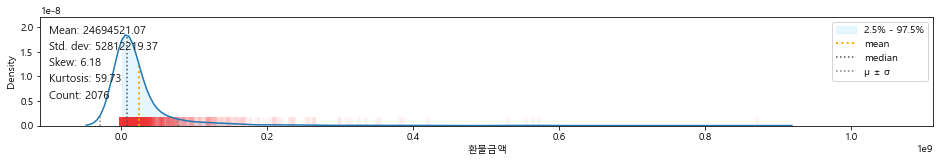

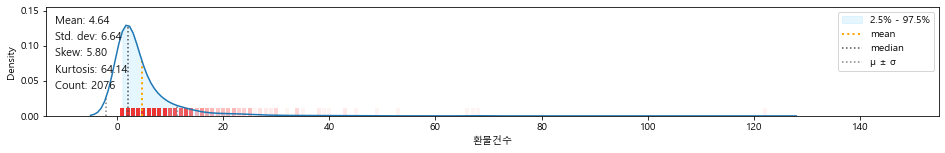

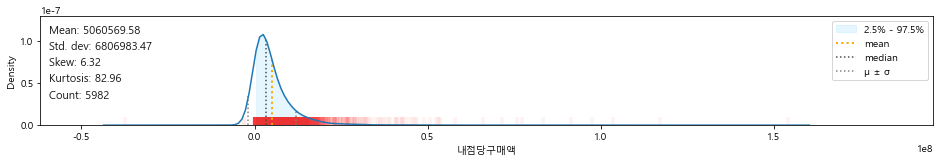

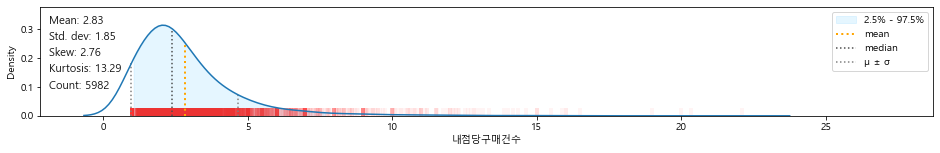

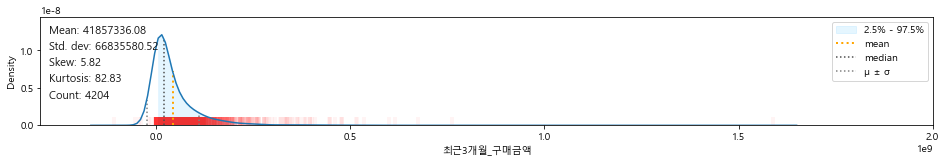

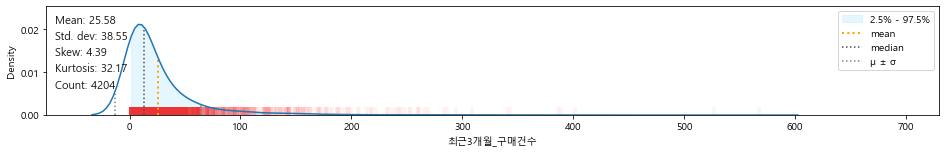

In [5]:
# 수치형 속성 파악

klib.dist_plot(features)

GridSpec(6, 2)

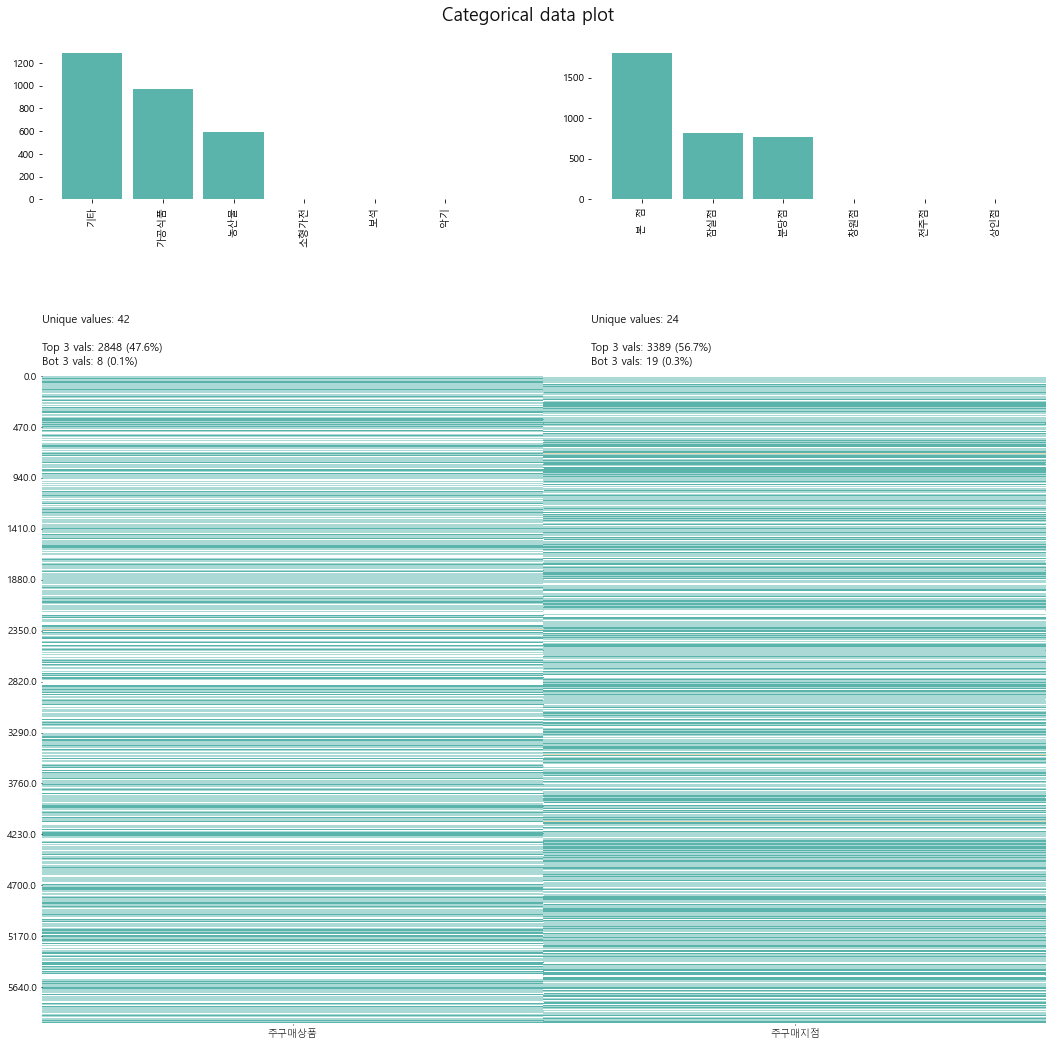

In [6]:
# 범주형 속성 파악

klib.cat_plot(features)

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to further limit the results.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

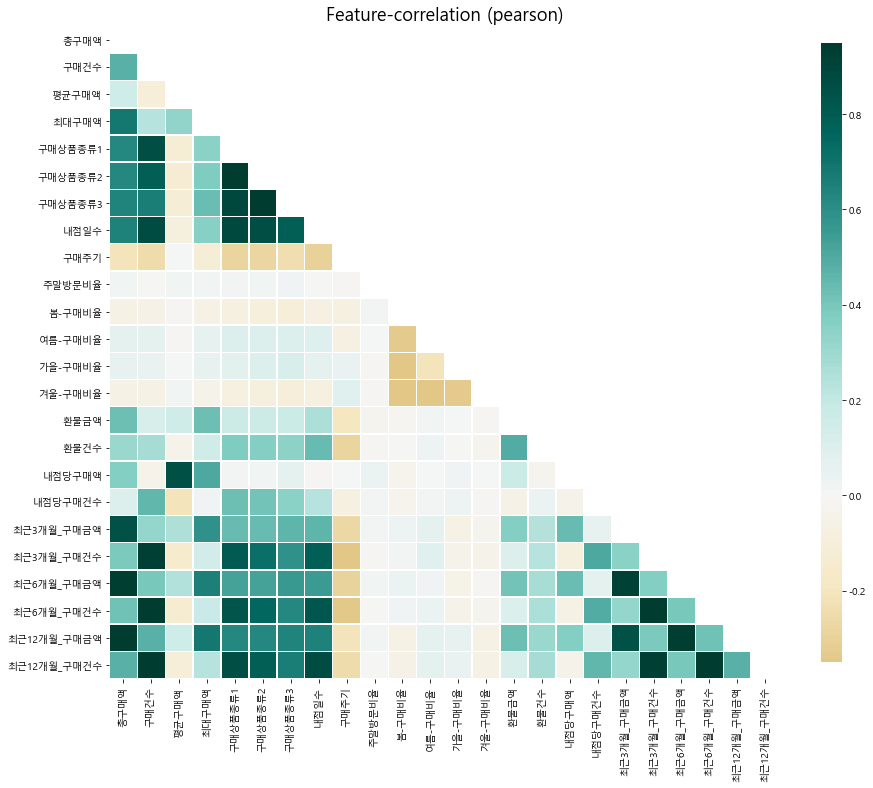

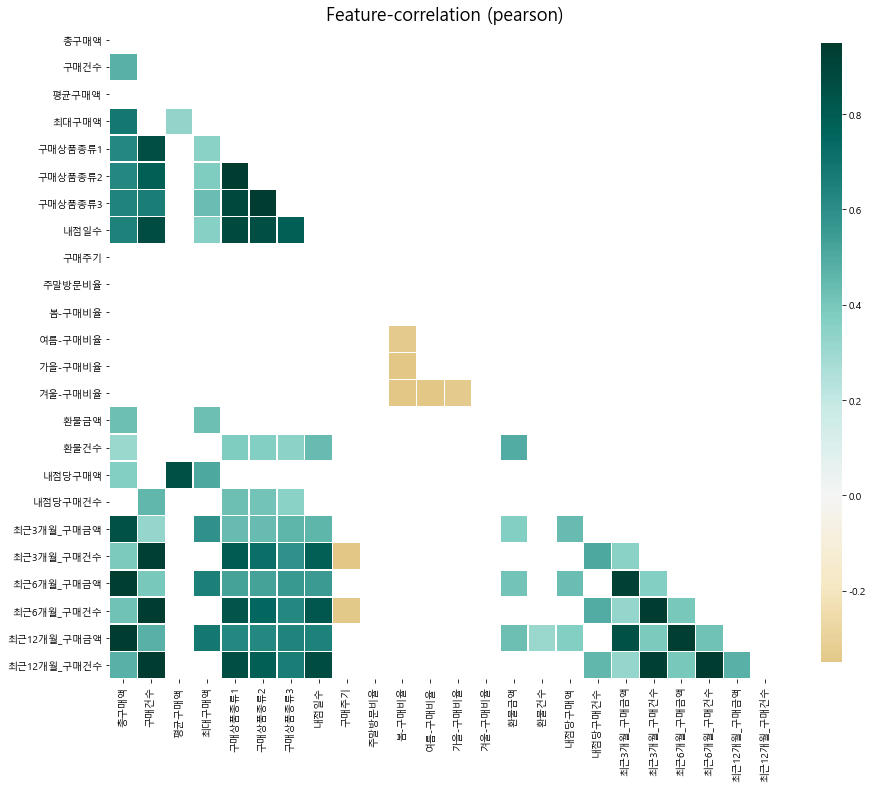

In [7]:
# 속성간 유사성 파악

klib.corr_plot(features, annot=False, figsize=(15,12))
klib.corr_plot(features, split='high', annot=False, figsize=(15,12))

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

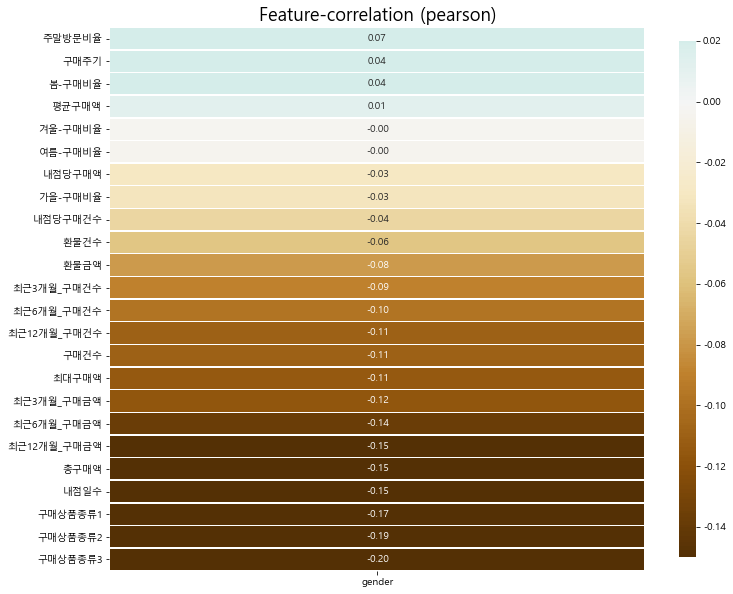

In [8]:
# 속성별 예측 능력 파악 

klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender')

### 3. Data Cleansing & Feature Engineering

In [9]:
# 범주형 변수와 수치형 변수를 분리
cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

*Impute Missing Values*

In [10]:
# 결측값 처리
features[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(features[num_features])
features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,68282840.0,74.0,922741.0,11264000.0,35.0,28.0,17.0,19.0,17.0,0.527027,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840.0,74.0,기타,강남점
1,2136000.0,3.0,712000.0,2136000.0,2.0,2.0,2.0,2.0,1.0,0.000000,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000.0,3.0,스포츠,잠실점
2,3197000.0,4.0,799250.0,1639000.0,1.0,2.0,2.0,2.0,1.0,0.000000,...,1.598500e+06,2.000000,0.0,0.0,0.0,0.0,3197000.0,4.0,기타,관악점
3,16077620.0,44.0,365400.0,4935000.0,24.0,20.0,13.0,18.0,16.0,0.318182,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620.0,44.0,기타,광주점
4,29050000.0,3.0,9683333.0,24000000.0,2.0,3.0,3.0,2.0,85.0,0.000000,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000.0,3.0,화장품,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500.0,14.0,5898679.0,23976000.0,8.0,7.0,7.0,8.0,40.0,0.642857,...,1.032269e+07,1.750000,36256000.0,5.0,44158500.0,7.0,82581500.0,14.0,골프,부산본점
5978,480000.0,1.0,480000.0,480000.0,1.0,1.0,1.0,1.0,0.0,0.000000,...,4.800000e+05,1.000000,0.0,0.0,0.0,0.0,480000.0,1.0,섬유잡화,광주점
5979,260003790.0,71.0,3662025.0,25750000.0,38.0,28.0,19.0,19.0,18.0,0.915493,...,1.368441e+07,3.736842,121061000.0,21.0,159653190.0,39.0,260003790.0,71.0,남성 캐주얼,본 점
5980,88991520.0,18.0,4943973.0,18120000.0,9.0,7.0,5.0,5.0,60.0,0.444444,...,1.779830e+07,3.600000,7528530.0,2.0,41243840.0,10.0,88991520.0,18.0,육류,본 점


*Deal with Outliers*

In [11]:
# 수치형 변수에 대해 이상치(outlier)를 처리
features[num_features] = features[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

*Transform Features*

In [12]:
# 수치형 변수를 정규분포에 가깝게 만들기
features[num_features] = PowerTransformer(standardize=True).fit_transform(features[num_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.850730,0.971813,0.634090,0.287488,0.961537,...,0.129368,0.982888,0.780602,1.019752,0.646088,1.090507,0.500815,0.829928,기타,강남점
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,-0.870911,-0.922585,0.144530,-0.248910,-0.247485,-0.585549,-1.122743,-1.112149,스포츠,잠실점
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,-0.569557,-0.364881,-1.422031,-1.239643,-1.660580,-1.393882,-0.966821,-0.963162,기타,관악점
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.519375,0.608433,0.593285,0.237687,0.328410,...,-0.995608,0.036812,-0.122657,-0.096410,-0.363700,0.073603,-0.260227,0.493805,기타,광주점
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-1.010055,-0.902317,-0.993810,1.730289,-1.318162,...,1.695438,-0.922585,0.759943,-0.448313,0.483017,-0.755419,0.035095,-1.112149,화장품,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.404322,-0.124258,-0.020766,1.085903,1.227595,...,1.263779,-0.627033,0.842808,0.026804,0.659400,-0.171612,0.611129,-0.232402,골프,부산본점
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.571532,-1.558223,-1.375368,-1.541375,-1.318162,...,-1.390357,-1.650387,-1.422031,-1.239643,-1.660580,-1.393882,-1.638093,-1.576152,섬유잡화,광주점
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.850730,1.130977,0.634090,0.335229,1.699113,...,1.617575,0.898985,1.210108,0.869827,1.185896,0.815361,1.333155,0.803103,남성 캐주얼,본 점
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.404322,-0.463380,-0.369851,1.531439,0.738583,...,1.782320,0.823236,0.429436,-0.448313,0.634141,0.020788,0.655202,-0.075760,육류,본 점


*Encode Categorical Variables*

In [13]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,주구매지점_안양점,주구매지점_영등포점,주구매지점_울산점,주구매지점_인천점,주구매지점_일산점,주구매지점_잠실점,주구매지점_전주점,주구매지점_창원점,주구매지점_청량리점,주구매지점_포항점
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.850730,0.971813,0.634090,0.287488,0.961537,...,0,0,0,0,0,0,0,0,0,0
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,0,0,0,0,0,1,0,0,0,0
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,0,0,0,0,0,0,0,0,0,0
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.519375,0.608433,0.593285,0.237687,0.328410,...,0,0,0,0,0,0,0,0,0,0
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-1.010055,-0.902317,-0.993810,1.730289,-1.318162,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.404322,-0.124258,-0.020766,1.085903,1.227595,...,0,0,0,0,0,0,0,0,0,0
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.571532,-1.558223,-1.375368,-1.541375,-1.318162,...,0,0,0,0,0,0,0,0,0,0
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.850730,1.130977,0.634090,0.335229,1.699113,...,0,0,0,0,0,0,0,0,0,0
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.404322,-0.463380,-0.369851,1.531439,0.738583,...,0,0,0,0,0,0,0,0,0,0


*Select Features*

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:26<00:00,  3.58it/s]

(58, 0.6837984473185028)


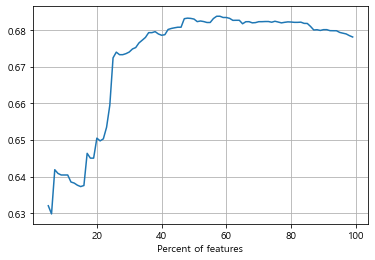

In [14]:
# 학습용과 제출용 데이터로 분리
features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
X_train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [15]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist())

(3500, 52)
['총구매액', '구매건수', '평균구매액', '최대구매액', '구매상품종류1', '구매상품종류2', '구매상품종류3', '내점일수', '구매주기', '주말방문비율', '봄-구매비율', '여름-구매비율', '가을-구매비율', '겨울-구매비율', '환불금액', '환불건수', '내점당구매액', '내점당구매건수', '최근3개월_구매금액', '최근3개월_구매건수', '최근6개월_구매금액', '최근6개월_구매건수', '최근12개월_구매금액', '최근12개월_구매건수', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_모피/피혁', '주구매상품_생활잡화', '주구매상품_섬유잡화', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_식기', '주구매상품_악기', '주구매상품_일용잡화', '주구매상품_젓갈/반찬', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_트래디셔널', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_대구점', '주구매지점_본  점', '주구매지점_부산본점', '주구매지점_안양점', '주구매지점_인천점', '주구매지점_전주점']


### 4. Model Tuning (Hyperparameter Optimization)

In [16]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [17]:
clfs = [
    (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        MLPClassifier(random_state=0),
        {'batch_size': ['auto', 32, 64, 128],
         'learning_rate' : ['constant', 'adaptive'],
         'activation': ['tanh', 'relu'],
         'solver': ['sgd', 'adam']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': np.arange(0.1, 1.1, 0.1),      
         'penalty': ['l1','l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [100,200,300],
         'max_depth': [None,3,4,5],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

 20%|████████████████▊                                                                   | 1/5 [00:04<00:19,  4.98s/it]

KNeighborsClassifier                                 0.604427 5.0


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:23<00:12,  6.25s/it]

MLPClassifier                                        0.672375 17.9
LogisticRegression                                   0.672296 0.2


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:27<00:05,  5.61s/it]

RandomForestClassifier                               0.647181 4.1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.49s/it]

GradientBoostingClassifier                           0.654585 10.3


### 5. Model Ensemble

*Correlation between models*

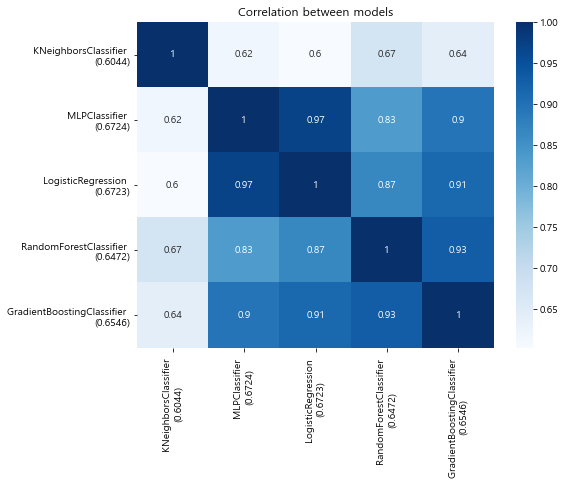

In [18]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [19]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

KNeighborsClassifier \n(0.6044)          0.633340
MLPClassifier \n(0.6724)                 0.829505
LogisticRegression \n(0.6723)            0.838751
RandomForestClassifier \n(0.6472)        0.826495
GradientBoostingClassifier \n(0.6546)    0.844949
dtype: float64

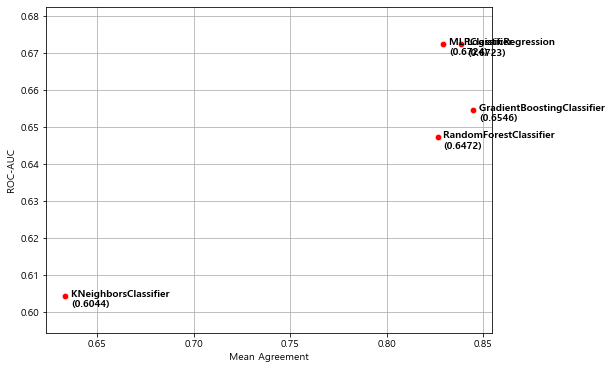

In [20]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

In [21]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',    
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [22]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.96s/it]

p=0
MLPClassifier●LogisticRegression
0.6733532711451063


In [23]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)    

*Stacking*

In [24]:
# 2-layer stacking

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.
selected = [
#    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',    
]

estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
stk_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=0), cv=3)

stk_clf.fit(X_train, y_train)
print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1]))  

0.6695797010111132


### 6. Deployment

In [25]:
# Averaging ensemble을 적용한 submission: (결과) 0.716574
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv('submission_avg.csv', index=False)

# Stacking ensemble을 적용한 submission: (결과) 0.717224
pd.DataFrame({'cust_id': test_id, 'gender': stk_clf.predict_proba(X_test)[:,1]}).to_csv('submission_stk.csv', index=False)

<font color="#CC3D3D"><p>
# End